# Comparison of online CCA algorithms

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cca_algorithms import bio_cca, gen_oja, msg_cca, asymmetric, bio_rrr
from util import correlation_matrix, error, msg_error, constraint_error, add_fill_lines

### Load synthetic dataset

In [2]:
# uncomment the desired dataset

# dataset = 'synthetic'
dataset = 'mediamill'

# load dataset

X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [3]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

# SVD

u, s, vh = np.linalg.svd(Rxy)

### Online algorithms

In [4]:
# Parameters

trials = 1; epochs = 3; z_dim = 1; iters = epochs*samples; training_samples = 1000

In [5]:
# Maximum of the objective

max_obj = sum(s[:z_dim])/2

In [6]:
if z_dim==1:
    genoja_err = np.zeros((trials,iters))

msgcca_err = np.zeros((trials,iters))
biocca_err = np.zeros((trials,iters))
biocca_constraint_err = np.zeros((trials,iters))
biorrr_err = np.zeros((trials,iters))
asycca_err = np.zeros((trials,iters))

In [7]:
for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize Bio-CCA

    biocca = bio_cca(z_dim,x_dim,y_dim,dataset)    
    biocca_Vx = np.zeros((iters,x_dim,z_dim))
    biocca_Vy = np.zeros((iters,y_dim,z_dim))
    
    # Initialize MSG-CCA
    
    msgcca = msg_cca(z_dim,x_dim,y_dim)
    msgcca_M = np.zeros((iters,x_dim,y_dim))

    # Initialize Gen-Oja
    
    if z_dim==1:
        genoja = gen_oja(x_dim,y_dim,dataset)
        genoja_vx = np.zeros((iters,x_dim,1))
        genoja_vy = np.zeros((iters,y_dim,1))
    
    # Initialize Asymmetric-CCA
    
    asycca = asymmetric(z_dim,x_dim,y_dim,dataset)
    asycca_Vx = np.zeros((iters,x_dim,z_dim))
    asycca_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Bio-RRR
    
    biorrr = bio_rrr(z_dim,x_dim,y_dim,dataset)
    biorrr_Vx = np.zeros((iters,x_dim,z_dim))
    biorrr_Vy = np.zeros((iters,y_dim,z_dim))
        
    # Run online algorithms
    
    print('Running online algorithms...')
    
    for i_epoch in range(epochs):
        
        print(f'Epoch {i_epoch+1} out of {epochs}:')
        
        # Random permutation of the inputs

        idx = np.random.permutation(samples)
    
        # MSG-CCA covariance estimation on training samples
        
        if i_epoch==0:
            msgcca.cov_estimation(X[:,idx[:]],Y[:,idx[:]])
            
        # Online updates

        for i_sample in range(samples):
            
            i_iter = i_epoch*samples + i_sample

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            # online updates

            biocca_Vx[i_iter], biocca_Vy[i_iter] = biocca.fit_next(x,y)
#             msgcca_M[i_iter] = msgcca.fit_next(x,y)
#             biorrr_Vx[i_iter], biorrr_Vy[i_iter] = biorrr.fit_next(x,y)
#             asycca_Vx[i_iter], asycca_Vy[i_iter] = asycca.fit_next(x,y)
            
            if z_dim==1:
                genoja_vx[i_iter], genoja_vy[i_iter] = genoja.fit_next(x,y)
        
    # Compute error
                
    print('Computing errors...')

    for i_iter in range(iters):
        if z_dim==1:
            genoja_err[i_trial,i_iter] = error(genoja_vx[i_iter], genoja_vy[i_iter], Cxx, Cyy, Cxy, max_obj)
            
#         msgcca_err[i_trial,i_iter] = msg_error(msgcca_M[i_iter], Rxy, max_obj)
        biocca_err[i_trial,i_iter] = error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
        biocca_constraint_err[i_trial,i_iter] = constraint_error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy)
#         biorrr_err[i_trial,i_iter] = error(biorrr_Vx[i_iter], biorrr_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
#         asycca_err[i_trial,i_iter] = error(asycca_Vx[i_iter], asycca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)

Trial 1 out of 1:
Running online algorithms...
Epoch 1 out of 3:
Epoch 2 out of 3:
Epoch 3 out of 3:
Computing errors...


### Comparison plots

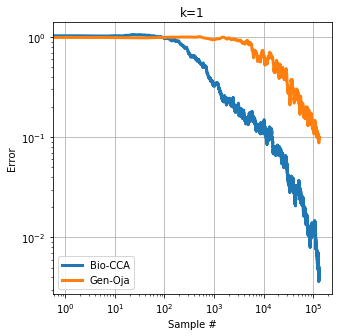

In [8]:
linewidth = 3

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, biocca_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-CCA'})
# add_fill_lines(ax, t, msgcca_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'MSG-CCA'})
# add_fill_lines(ax, t, asycca_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Asymmetric network'})
# add_fill_lines(ax, t, biorrr_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-RRR'})

if z_dim==1:
    add_fill_lines(ax, t, genoja_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Gen-Oja'})

ax.loglog()

plt.title(f"k={z_dim}")
plt.grid()
# plt.xlim(1,10**5)
plt.legend(loc = 'lower left')
plt.xlabel('Sample #')
plt.ylabel('Error')

plt.show()